In [27]:
%cd /isilon/data/users/jpfeife2/jetAnomalyDetection

/isilon/data/users/jpfeife2/jetAnomalyDetection


In [1]:
from torch.optim import Adam
from torch.nn import MSELoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np 
from torchinfo import summary
import torch
import pandas as pd 
import glob 
import os
from scipy.spatial.distance import cdist
import torch.nn as nn 
import torch.nn.functional as F
from sklearn import preprocessing
from scipy.stats import skew

In [28]:
from models import Autoencoder, train_model, Transformer, SmallAutoencoder
from model_analysis import plot_loss, plot_anomaly_score, plot_roc
import constants as c 

In [2]:
from fast_histogram import histogram2d

ETA_MIN = -0.8 
ETA_MAX = 0.8 
PHI_MIN = -0.8 
PHI_MAX = 0.8 
INCR = 0.05 
BINS = int(abs(ETA_MIN - ETA_MAX)/INCR)

def make_histogram(eta, phi, cc):
    hist_range = [[ETA_MIN, ETA_MAX], [PHI_MIN, PHI_MAX]]
    eta_bins = np.arange(ETA_MIN, ETA_MAX, INCR)
    phi_bins = np.arange(PHI_MIN, PHI_MAX, INCR)
    image_shape = (eta_bins.shape[0], phi_bins.shape[0])

    return histogram2d(phi, eta, range=hist_range, bins=image_shape, weights=cc)

In [35]:
def plot_property_distribution2(background_data, signal_data, prop_name, background_label, signal_label):
    fig, ax = plt.subplots()
    ax.set_title("Distribution of " + prop_name )
    ax.set_xlabel(prop_name)

    bins = 150

    bin_range = (np.min([np.min(background_data), np.min(signal_data)]),
            np.max([np.max(background_data), np.max(signal_data)]))
    

    ax.hist(background_data, density=True, label=background_label, alpha=0.5, bins=bins, range=bin_range)
    ax.hist(signal_data, density=True, label=signal_label, alpha=0.5, bins=bins, range=bin_range)
    plt.legend()
    # plt.yscale('log')
#     plt.savefig("plots/" + prop_name + "_distribution.png")
    plt.show()
    plt.close(fig)

In [4]:
background_label = "qcd400to500"
signal_label = "wjet400to500"
props = ['pt']
data_dir = "/isilon/data/users/jpfeife2/AutoEncoder-Anomaly-Detection/processed_data"

In [5]:
n_props = len(props)
prop_string = ''.join(['_' + str(prop) for prop in props])

In [6]:
pkl_files = glob.glob(os.path.join(data_dir, f'*{background_label}*.pkl'))
background_raw = pd.concat([pd.read_pickle(file) for file in pkl_files], ignore_index=True)

pkl_files = glob.glob(os.path.join(data_dir, f'*{signal_label}*.pkl'))
signal_raw = pd.concat([pd.read_pickle(file) for file in pkl_files], ignore_index=True)
print("FILES LOADED")


FILES LOADED


In [88]:
def format_2D(data, properties, scalers=None, med = 0.0):
    hists = []
    n_properties = len(properties)
    if scalers == None: 
        scalers = []
    vals = []

    for i, prop in enumerate(properties): 
        vals.append([])
        # flattened_list = [item for sublist in data[prop] for item in sublist if item < 0.2]
        # # unique_values_list = sorted(list(set(flattened_list)))
        # flattened_list = np.log(flattened_list)

        # if len(scalers) < i + 1:
        #     scaler = preprocessing.StandardScaler(with_mean = False)
        #     flat_list = scaler.fit_transform(np.array(flattened_list).reshape(-1,1))
        #     med = np.median(flat_list)          
        #     scalers.append(scaler)


        hist_list = []
        for j in range(data.shape[0]):
            prop_data = data[prop][j]
            # print(prop_data)
            pt_cut = np.where(np.array(prop_data) <= 0.2)[0]
            # print(pt_cut)
            prop_data = (np.array(prop_data)*5)[pt_cut] 
            if len(prop_data) > 0: 
                filtered_eta = np.array(data['eta'][j])[pt_cut].flatten()
                filtered_phi = np.log(np.array(data['phi'][j])[pt_cut]).flatten()
                vals[i].extend(np.log(prop_data))
                hist_list.append(make_histogram(filtered_eta, filtered_phi, prop_data))
            else: 
                hist_list.append(make_histogram([], [], []))
        # hists.append([make_histogram(data['eta'][j], data['phi'][j], (scalers[i].transform(np.log(np.array(data[prop][j]).reshape(-1,1))) - med).flatten()) for j in range(data.shape[0])])
        hists.append(hist_list)
        # l = (scalers[i].transform((np.array(flattened_list).reshape(-1,1))) - med).flatten()
        # vals[i].extend(l)

    total_hist = np.stack((hists), axis=-1)
    total_hist = np.reshape(total_hist, (-1, c.BINS, c.BINS, n_properties)).astype('float32')

    print("Length of data: ", len(total_hist))
    return total_hist, scalers, vals, med

In [89]:
background, scalers, background_data, med = format_2D(background_raw, properties=props, scalers=None)
np.save(data_dir + "/" + background_label + prop_string + ".npy", background)
print("BACKGROUND LOADED AND SAVED")

signal, _, signal_data, _ = format_2D(signal_raw, properties=props, scalers=scalers, med=med)
np.save(data_dir + "/" + signal_label + prop_string + ".npy", signal)
print("SIGNAL LOADED AND SAVED")

/tmp/ipykernel_3656958/1840359157.py:30: RuntimeWarning: invalid value encountered in log
  filtered_phi = np.log(np.array(data['phi'][j])[pt_cut]).flatten()
/tmp/ipykernel_3656958/1840359157.py:30: RuntimeWarning: divide by zero encountered in log
  filtered_phi = np.log(np.array(data['phi'][j])[pt_cut]).flatten()


Length of data:  118845
BACKGROUND LOADED AND SAVED
Length of data:  19914
SIGNAL LOADED AND SAVED


In [90]:
med = np.median(background_data[0])
print(med)

-3.143473


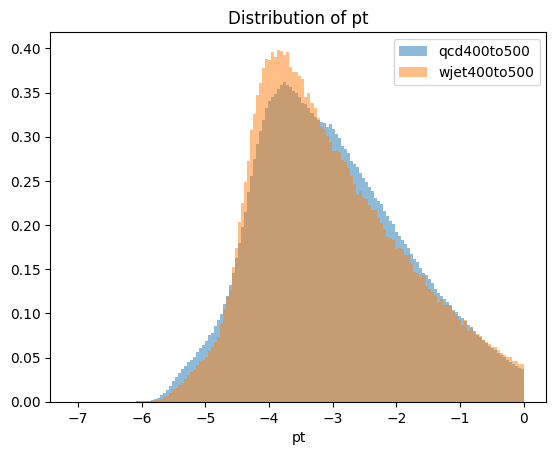

In [92]:
for i, prop in enumerate(props): 
    plot_property_distribution2(background_data[i], signal_data[i], prop, background_label, signal_label)


In [ ]:
print(np.mean(background_data[0]))
print(np.median(background_data[0]))
print(np.std(background_data[0]))

0.10123935
0.043132745
0.14982751


In [93]:
batch_size = 20
epochs = 8
initial_lr = 0.001
weight_decay = 1e-3
latent_dim = 12

In [94]:
print("Background events: ", len(background))
print("Signal events: ", len(signal))
train_data, test_data = train_test_split(background, test_size = 0.2)
input_shape = train_data.shape
n_props = input_shape[-1]
print(input_shape)

X_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
X_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
X_valid_dataloader = DataLoader(signal, batch_size=batch_size, shuffle=False)

print("Data Loaded!")


Background events:  118845
Signal events:  19914
(95076, 32, 32, 1)
Data Loaded!


In [95]:
model = Transformer(input_size = input_shape, latent_dim=latent_dim)
optimizer = torch.optim.AdamW(model.parameters(), lr=initial_lr, weight_decay=weight_decay)

summary(model, input_size=(batch_size, c.BINS, c.BINS, n_props))

criterion = MSELoss(reduction='mean')


/isilon/data/users/jpfeife2/miniforge3/envs/anomaly/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [96]:

#=============== Run Model =========
print("Training Model... ")
torch.set_num_threads(3)
train_loss, test_loss, signal_loss = train_model(
    train_dataloader = X_train_dataloader, 
    test_dataloader = X_test_dataloader, 
    signal_dataloader= X_valid_dataloader,
    model = model, 
    loss_fn = MSELoss(reduction='mean'), 
    optimizer = optimizer, 
    epochs = epochs, 
    batch_size = batch_size )

torch.save(model, "model")

Training Model... 


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [03:59<00:00, 29.91s/it]


Analyzing Results... 


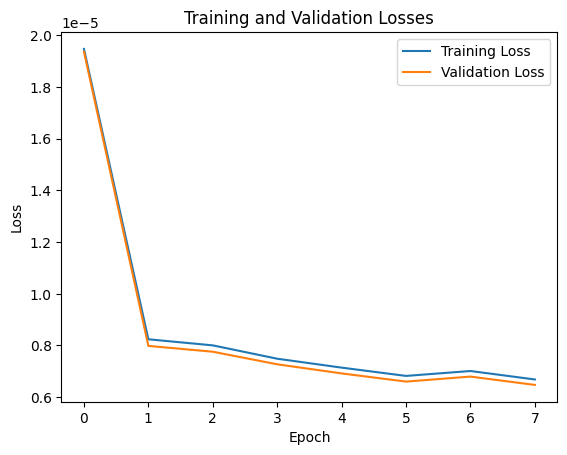

<Figure size 640x480 with 0 Axes>

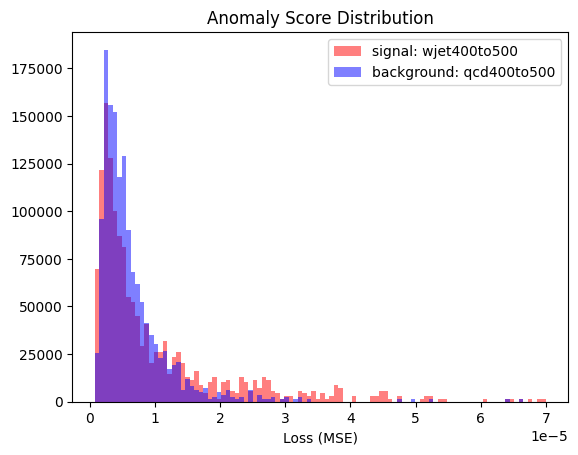

<Figure size 640x480 with 0 Axes>

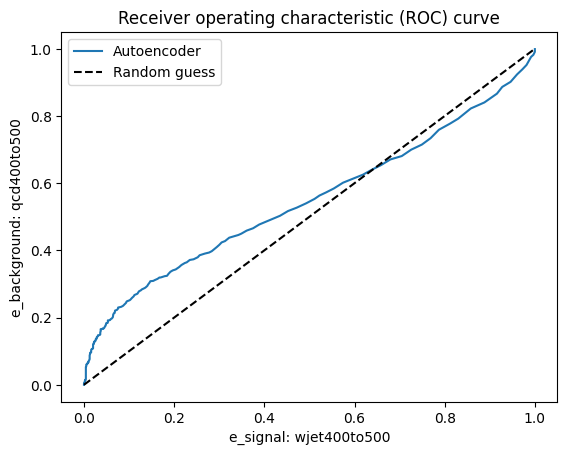

AUC: 0.549
Done!


<Figure size 640x480 with 0 Axes>

In [98]:
#============== Save Analysis========
print("Analyzing Results... ")
plot_loss(model.train_hist, model.val_hist)
plot_anomaly_score(model.background_test_loss, model.signal_loss, background_label, signal_label)
plot_roc(model, signal_label, background_label, examples=False, loss_fn=MSELoss(reduction='mean'), properties=props)
print("Done!")